**<h1>Captioning Model Fine-tuning Using LoRA Technique</h1>**

# Import libraries

In [ ]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as opt
from torchvision import transforms

from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from peft import LoraConfig, get_peft_model

import warnings
warnings.filterwarnings(action='ignore')

c:\Users\reube\anaconda3\envs\Portfolio_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define configurations

In [2]:
CONFIG = {
    'MODEL_VITGPT': 'nlpconnect/vit-gpt2-image-captioning',
    'CSV_FILEPATH': "../../data/dataset_csv_file/dataset_captioning.csv",
    'IMG_FILEPATH': "../../",
    'BATCH_SIZE': 2,
    'EPOCHS': 20,
    'LR': 1e-4,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "MODEL_SAVE_DIR": "../../models/final_model/caption_model",
    "WEIGHT_DECAY": 1e-2,

    "TRAIN_RATIO": 0.7,
    'VAL_RATIO': 0.2,
    'TEST_RATIO': 0.1,
    'SEED': 42,
    
    'PATIENCE': 3,
    'LOW_RANK': 8,
}

if CONFIG['DEVICE'] == "cuda":
    print(f"Using GPU")
else:
    print(f"Using CPU")

Using GPU


In [3]:
train_transformers = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.15, saturation=0.05, hue=0.02)
])

eval_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224))
])

# Define the model and the processor (and tokenizers)

In [4]:
# Define the model ViT + GPT2, processor, and the tokenizer and freeze their model parameters
vitgpt_model = VisionEncoderDecoderModel.from_pretrained(CONFIG['MODEL_VITGPT'])
vitgpt_processor, vitgpt_tokenizer = ViTImageProcessor.from_pretrained(CONFIG['MODEL_VITGPT']), AutoTokenizer.from_pretrained(CONFIG['MODEL_VITGPT'])

for params in vitgpt_model.parameters():
    params.requires_grad = False

vit_lora_config = LoraConfig(
    r = CONFIG['LOW_RANK'],
    lora_alpha = 16,
    lora_dropout = 0.05,
    bias = 'none',
    target_modules=['q_attn'],
    task_type = 'SEQ_2_SEQ_LM'
)

In [5]:
vitgpt_model = get_peft_model(vitgpt_model, vit_lora_config)
vitgpt_model.to(CONFIG['DEVICE'])
vitgpt_model.print_trainable_parameters()

trainable params: 147,456 || all params: 239,343,360 || trainable%: 0.0616


# Define Dataset Class and Loader

In [6]:
class CarCrashDataset(Dataset):
    def __init__(self, csv_file: str, img_root: str, processor, img_transform: transforms = None, tokenizers = None):
        super().__init__()
        try:
            self.__data = pd.read_csv(csv_file)
        except FileNotFoundError as e:
            print(f"File not found: {e}")
            return
        
        self.__processor = processor
        self.__img_root = img_root
        self.img_transforms = img_transform
        self.__tokenizer = tokenizers

    def __len__(self):
        return len(self.__data)
    
    def __getitem__(self, idx):
        row = self.__data.iloc[idx]
        img_path = row['filepath']
        caption = row['caption']

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")

        image = Image.open(img_path).convert('RGB')
        if self.img_transforms:
            image = self.img_transforms(image)
        
        pixel_val = self.__processor(
            images = image,
            return_tensors = "pt"
        ).pixel_values

        labels = self.__tokenizer(
            caption,
            return_tensors = "pt",
            padding = "max_length",
            truncation = True
        )

        image_data = {
            "pixel_values": pixel_val.squeeze(0),
            "input_ids": labels["input_ids"].squeeze(0),
            "attention_mask": labels["attention_mask"].squeeze(0),
            "labels": labels["input_ids"].squeeze(0),
        }

        return image_data

## Define ViTGPT dataset

In [7]:
car_vitgpt_dataset = CarCrashDataset(CONFIG['CSV_FILEPATH'], CONFIG['IMG_FILEPATH'], processor=vitgpt_processor, img_transform=train_transformers, tokenizers=vitgpt_tokenizer)

train_len = int(CONFIG['TRAIN_RATIO'] * len(car_vitgpt_dataset))
val_len = int(CONFIG['VAL_RATIO'] * len(car_vitgpt_dataset))
test_len = len(car_vitgpt_dataset) - train_len - val_len

In [8]:
data_generator = torch.Generator().manual_seed(CONFIG['SEED'])

train_data, val_data, test_data = random_split(dataset=car_vitgpt_dataset, lengths=[train_len, val_len, test_len], generator=data_generator)

train_data.dataset.img_transforms = train_transformers
val_data.dataset.img_transforms = eval_transforms
test_data.dataset.img_transforms = eval_transforms

In [9]:
train_vitgpt_loader = DataLoader(dataset=train_data, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)
val_vitgpt_loader = DataLoader(dataset=val_data, batch_size=CONFIG['BATCH_SIZE'], shuffle=False)
test_vitgpt_loader = DataLoader(dataset=test_data, batch_size=CONFIG['BATCH_SIZE'], shuffle=False)

# Training & Validation Process

In [10]:
def train_model(model, train_loader, val_loader, model_name):
    optimizer = opt.AdamW(model.parameters(), lr=CONFIG['LR'], weight_decay=CONFIG['WEIGHT_DECAY'])

    best_val_loss = float('inf') # Smaller is better
    epochs_no_improve_count = 0
    train_loss_arr, val_loss_arr = [], []

    for epoch in range(CONFIG['EPOCHS']):
        print(f"\nEpoch {epoch + 1} / {CONFIG['EPOCHS']}")
        model.train()
        train_loss = 0.0

        # Training Process
        for img_batch in tqdm(train_loader, desc=f"{model_name} EPOCH {epoch + 1} [Train]"):
            optimizer.zero_grad()

            output = model(**{k: v.to(CONFIG['DEVICE']) for k, v in img_batch.items()})

            loss = output.loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_loss_arr.append(train_loss)

        # Validation Process
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for img_batch in tqdm(val_loader, desc=f"EPOCH {epoch + 1} [Validation]"):
                output = model(**{k: v.to(CONFIG['DEVICE']) for k, v in img_batch.items()})
                val_loss += output.loss.item()

        val_loss /= len(val_loader)
        val_loss_arr.append(val_loss)

        print(f"{model_name} | EPOCH {epoch + 1}: Train Loss = {train_loss:.4f} ; Val Loss = {val_loss:.4f}")

        # Add early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve_count = 0

            # Save the model. Overwrite if better loss
            os.makedirs(f"../../models/runs/captioning_model/{model_name}", exist_ok=True)

            model.save_pretrained(f"../../models/runs/captioning_model/{model_name}")

        else:
            epochs_no_improve_count += 1
            if epochs_no_improve_count >= CONFIG['PATIENCE']:
                print(f"Early Stopping triggered")
                break

    return train_loss_arr, val_loss_arr, best_val_loss

In [11]:
vitgpt_train_loss_arr, vitgpt_val_loss_arr, vitgpt_best_val_loss = train_model(model=vitgpt_model, train_loader=train_vitgpt_loader, val_loader=val_vitgpt_loader, model_name='ViT-GPT2')


Epoch 1 / 20


ViT-GPT2 EPOCH 1 [Train]:   0%|          | 0/425 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
EPOCH 1 [Validation]: 100%|██████████| 121/121 [00:12<00:00, 10.04it/s]


ViT-GPT2 | EPOCH 1: Train Loss = 3.8657 ; Val Loss = 2.9950

Epoch 2 / 20


EPOCH 2 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.17it/s]


ViT-GPT2 | EPOCH 2: Train Loss = 1.8878 ; Val Loss = 2.3892

Epoch 3 / 20


EPOCH 3 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.16it/s]


ViT-GPT2 | EPOCH 3: Train Loss = 1.5520 ; Val Loss = 2.0706

Epoch 4 / 20


EPOCH 4 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.13it/s]


ViT-GPT2 | EPOCH 4: Train Loss = 1.3541 ; Val Loss = 1.8793

Epoch 5 / 20


EPOCH 5 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.14it/s]


ViT-GPT2 | EPOCH 5: Train Loss = 1.2234 ; Val Loss = 1.7274

Epoch 6 / 20


EPOCH 6 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.15it/s]


ViT-GPT2 | EPOCH 6: Train Loss = 1.1116 ; Val Loss = 1.6245

Epoch 7 / 20


EPOCH 7 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.14it/s]


ViT-GPT2 | EPOCH 7: Train Loss = 1.0438 ; Val Loss = 1.5027

Epoch 8 / 20


EPOCH 8 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.17it/s]


ViT-GPT2 | EPOCH 8: Train Loss = 0.9634 ; Val Loss = 1.4398

Epoch 9 / 20


EPOCH 9 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.18it/s]


ViT-GPT2 | EPOCH 9: Train Loss = 0.8963 ; Val Loss = 1.3830

Epoch 10 / 20


EPOCH 10 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.18it/s]


ViT-GPT2 | EPOCH 10: Train Loss = 0.8520 ; Val Loss = 1.3314

Epoch 11 / 20


EPOCH 11 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.20it/s]


ViT-GPT2 | EPOCH 11: Train Loss = 0.8133 ; Val Loss = 1.2884

Epoch 12 / 20


EPOCH 12 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.23it/s]


ViT-GPT2 | EPOCH 12: Train Loss = 0.7839 ; Val Loss = 1.2502

Epoch 13 / 20


EPOCH 13 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.24it/s]


ViT-GPT2 | EPOCH 13: Train Loss = 0.7617 ; Val Loss = 1.2278

Epoch 14 / 20


EPOCH 14 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.16it/s]


ViT-GPT2 | EPOCH 14: Train Loss = 0.7423 ; Val Loss = 1.1929

Epoch 15 / 20


EPOCH 15 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.18it/s]


ViT-GPT2 | EPOCH 15: Train Loss = 0.7182 ; Val Loss = 1.1758

Epoch 16 / 20


EPOCH 16 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.18it/s]


ViT-GPT2 | EPOCH 16: Train Loss = 0.7104 ; Val Loss = 1.1596

Epoch 17 / 20


EPOCH 17 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.17it/s]


ViT-GPT2 | EPOCH 17: Train Loss = 0.6921 ; Val Loss = 1.1412

Epoch 18 / 20


EPOCH 18 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.13it/s]


ViT-GPT2 | EPOCH 18: Train Loss = 0.6810 ; Val Loss = 1.1231

Epoch 19 / 20


EPOCH 19 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.13it/s]


ViT-GPT2 | EPOCH 19: Train Loss = 0.6681 ; Val Loss = 1.1173

Epoch 20 / 20


EPOCH 20 [Validation]: 100%|██████████| 121/121 [00:11<00:00, 10.13it/s]


ViT-GPT2 | EPOCH 20: Train Loss = 0.6573 ; Val Loss = 1.1067


# Comparing models

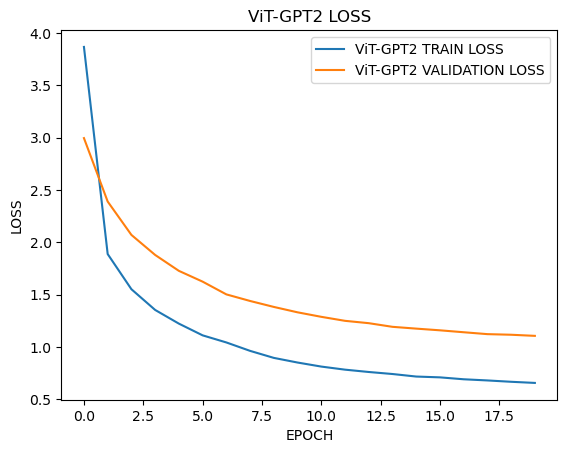

In [12]:
# View VITGPT performance
plt.figure()
plt.plot(vitgpt_train_loss_arr, label='ViT-GPT2 TRAIN LOSS')
plt.plot(vitgpt_val_loss_arr, label='ViT-GPT2 VALIDATION LOSS')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.title(f"ViT-GPT2 LOSS")
plt.legend()
plt.show()

# Testing Process

In [13]:
def test_model(model, test_loader):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for img_batch in tqdm(test_loader, desc=f"Testing"):
            output = model(**{k: v.to(CONFIG['DEVICE']) for k, v in img_batch.items()})
            test_loss += output.loss.item()
        
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")    

In [14]:
test_model(vitgpt_model, test_vitgpt_loader)

Testing: 100%|██████████| 62/62 [00:06<00:00,  9.91it/s]

Test Loss: 1.0752


In [15]:
vitgpt_model.save_pretrained(CONFIG['MODEL_SAVE_DIR'])
vitgpt_processor.save_pretrained(CONFIG['MODEL_SAVE_DIR'])
vitgpt_tokenizer.save_pretrained(CONFIG['MODEL_SAVE_DIR'])

('../../models/final_model/caption_model\\tokenizer_config.json',
 '../../models/final_model/caption_model\\special_tokens_map.json',
 '../../models/final_model/caption_model\\vocab.json',
 '../../models/final_model/caption_model\\merges.txt',
 '../../models/final_model/caption_model\\added_tokens.json',
 '../../models/final_model/caption_model\\tokenizer.json')